In [1]:
# ============================================================================
# SEGMENT 1: IMPORTS AND SETUP
# ============================================================================
# Run this segment first to import all required libraries

import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# NLP and preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    precision_recall_fscore_support
)

# Download required NLTK data
print("Downloading NLTK resources...")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)
print("✓ Setup complete!")


✓ Setup complete!


In [8]:
print(df.columns)


Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


In [9]:
# ============================================================================
# SEGMENT 2: DATA LOADING AND EXPLORATION
# ============================================================================
# Load your dataset and explore it

# IMPORTANT: Update this path to your actual CSV file location
filepath = 'Reviews.csv'  # ← CHANGE THIS TO YOUR FILE PATH

# Load the data
print("Loading data...")
df = pd.read_csv(filepath)

# Display basic information
print(f"\nDataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nFirst 5 rows:")
print(df.head())

print(f"\nData types:")
print(df.dtypes)

print(f"\nMissing values:")
print(df.isnull().sum())

print(f"\nBasic statistics:")
print(df.describe())

# Check the distribution of ratings (if you have a rating column)
if 'rating' in df.columns:
    print(f"\nRating distribution:")
    print(df['rating'].value_counts().sort_index())



Loading data...

Dataset shape: (568454, 10)

Column names: ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']

First 5 rows:
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0

In [10]:
# ============================================================================
# SEGMENT 3: CREATE SENTIMENT LABELS
# ============================================================================
# Convert ratings to binary sentiment (positive/negative)

# IMPORTANT: Adjust these column names based on your dataset
text_column = 'Text'  # ← Name of your review text column
rating_column = 'Score'  # ← Name of your rating column (1-5 scale)
threshold = 3  # ← Scores > 3 = positive (4-5), <= 3 = negative (1-3)

# Create sentiment labels
# 1 = Positive, 0 = Negative
df['sentiment'] = (df[rating_column] > threshold).astype(int)

print("Sentiment Labels Created!")
print(f"\nSentiment distribution:")
print(df['sentiment'].value_counts())

positive_count = df['sentiment'].sum()
negative_count = len(df) - positive_count
print(f"\nPositive reviews: {positive_count} ({positive_count/len(df)*100:.2f}%)")
print(f"Negative reviews: {negative_count} ({negative_count/len(df)*100:.2f}%)")

# Show some examples
print("\n--- Sample Positive Reviews ---")
print(df[df['sentiment'] == 1][text_column].head(3).values)

print("\n--- Sample Negative Reviews ---")
print(df[df['sentiment'] == 0][text_column].head(3).values)


Sentiment Labels Created!

Sentiment distribution:
sentiment
1    443777
0    124677
Name: count, dtype: int64

Positive reviews: 443777 (78.07%)
Negative reviews: 124677 (21.93%)

--- Sample Positive Reviews ---
['I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'
 'This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis\' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.'
 'Grea

In [11]:
# ============================================================================
# SEGMENT 4: TEXT PREPROCESSING CLASS
# ============================================================================
# Define the preprocessing pipeline

class TextPreprocessor:
    """Complete text preprocessing pipeline"""
    
    def __init__(self, use_stemming=False):
        self.stop_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer() if use_stemming else None
        
    def clean_text(self, text):
        """Clean and normalize text"""
        if pd.isna(text):
            return ""
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        
        # Remove email addresses
        text = re.sub(r'\S+@\S+', '', text)
        
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        
        # Remove extra whitespace
        text = ' '.join(text.split())
        
        return text
    
    def remove_stopwords(self, text):
        """Remove common stopwords"""
        tokens = word_tokenize(text)
        filtered_tokens = [word for word in tokens if word not in self.stop_words]
        return ' '.join(filtered_tokens)
    
    def apply_stemming(self, text):
        """Apply stemming to reduce words to root form"""
        if self.stemmer:
            tokens = word_tokenize(text)
            stemmed = [self.stemmer.stem(word) for word in tokens]
            return ' '.join(stemmed)
        return text
    
    def preprocess(self, text):
        """Complete preprocessing pipeline"""
        text = self.clean_text(text)
        text = self.remove_stopwords(text)
        text = self.apply_stemming(text)
        return text

print("✓ TextPreprocessor class defined!")

✓ TextPreprocessor class defined!


In [12]:
# ============================================================================
# SEGMENT 5: APPLY PREPROCESSING
# ============================================================================
# Clean all reviews in the dataset

print("Preprocessing reviews...")
preprocessor = TextPreprocessor(use_stemming=False)

# Apply preprocessing to all reviews
df['cleaned_review'] = df[text_column].apply(preprocessor.preprocess)

# Show preprocessing examples
print("\n--- Preprocessing Examples ---")
for i in range(min(5, len(df))):
    print(f"\n{i+1}. ORIGINAL:")
    print(f"   {df[text_column].iloc[i][:150]}...")
    print(f"   CLEANED:")
    print(f"   {df['cleaned_review'].iloc[i][:150]}...")
    print("-" * 80)

# Check for any empty reviews after cleaning
empty_reviews = df['cleaned_review'].str.strip().eq('').sum()
print(f"\nEmpty reviews after cleaning: {empty_reviews}")

if empty_reviews > 0:
    print("Removing empty reviews...")
    df = df[df['cleaned_review'].str.strip() != '']
    print(f"New dataset shape: {df.shape}")

print("\n✓ Preprocessing complete!")

Preprocessing reviews...

--- Preprocessing Examples ---

1. ORIGINAL:
   I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than ...
   CLEANED:
   bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates ...
--------------------------------------------------------------------------------

2. ORIGINAL:
   Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor inten...
   CLEANED:
   product arrived labeled jumbo salted peanutsthe peanuts actually small sized unsalted sure error vendor intended represent product jumbo...
--------------------------------------------------------------------------------

3. ORIGINAL:
   This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin 

In [13]:
# ============================================================================
# SEGMENT 6: SPLIT DATA AND CREATE TF-IDF FEATURES
# ============================================================================
# Split into train/test sets and convert text to numerical features

print("Splitting data into train and test sets...")

X = df['cleaned_review']
y = df['sentiment']

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Ensures balanced split
)

print(f"Training set size: {len(X_train)} ({len(X_train)/len(df)*100:.1f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(df)*100:.1f}%)")

print(f"\nTrain sentiment distribution:")
print(y_train.value_counts())
print(f"\nTest sentiment distribution:")
print(y_test.value_counts())

# Create TF-IDF features
print("\n" + "="*60)
print("Creating TF-IDF features...")
print("="*60)

vectorizer = TfidfVectorizer(
    max_features=5000,      # Use top 5000 words
    ngram_range=(1, 2),     # Use single words and word pairs
    min_df=2,               # Word must appear in at least 2 documents
    max_df=0.8              # Ignore words appearing in >80% of documents
)

# Fit on training data and transform both sets
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"\nTF-IDF matrix shape (train): {X_train_tfidf.shape}")
print(f"TF-IDF matrix shape (test): {X_test_tfidf.shape}")
print(f"Number of features (words): {len(vectorizer.get_feature_names_out())}")

# Show some example features
feature_names = vectorizer.get_feature_names_out()
print(f"\nSample features: {feature_names[:20]}")

print("\n✓ Feature extraction complete!")

Splitting data into train and test sets...
Training set size: 454762 (80.0%)
Test set size: 113691 (20.0%)

Train sentiment distribution:
sentiment
1    355020
0     99742
Name: count, dtype: int64

Test sentiment distribution:
sentiment
1    88756
0    24935
Name: count, dtype: int64

Creating TF-IDF features...

TF-IDF matrix shape (train): (454762, 5000)
TF-IDF matrix shape (test): (113691, 5000)
Number of features (words): 5000

Sample features: ['ability' 'able' 'able buy' 'able find' 'able get' 'abr' 'abr br'
 'absolute' 'absolute favorite' 'absolutely' 'absolutely delicious'
 'absolutely love' 'absolutely loves' 'acai' 'acceptable' 'access'
 'accident' 'according' 'account' 'accurate']

✓ Feature extraction complete!


In [14]:
# ============================================================================
# SEGMENT 7: TRAIN THE MODEL
# ============================================================================
# Train Naive Bayes classifier

print("="*60)
print("TRAINING NAIVE BAYES CLASSIFIER")
print("="*60)

# Create and train the model
model = MultinomialNB(alpha=1.0)
model.fit(X_train_tfidf, y_train)

print("✓ Model training complete!")

# Make predictions on training data (to check for overfitting)
train_predictions = model.predict(X_train_tfidf)
train_accuracy = accuracy_score(y_train, train_predictions)

print(f"\nTraining Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")


TRAINING NAIVE BAYES CLASSIFIER
✓ Model training complete!

Training Accuracy: 0.8493 (84.93%)


In [15]:
# ============================================================================
# SEGMENT 8: EVALUATE THE MODEL
# ============================================================================
# Test the model and show performance metrics

print("\n" + "="*60)
print("MODEL EVALUATION ON TEST DATA")
print("="*60)

# Make predictions on test data
y_pred = model.predict(X_test_tfidf)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Detailed classification report
print("\n" + "-"*60)
print("CLASSIFICATION REPORT")
print("-"*60)
print(classification_report(y_test, y_pred, 
                          target_names=['Negative (0)', 'Positive (1)'],
                          digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)
print("\nInterpretation:")
print(f"True Negatives (correctly predicted negative): {cm[0,0]}")
print(f"False Positives (predicted positive, actually negative): {cm[0,1]}")
print(f"False Negatives (predicted negative, actually positive): {cm[1,0]}")
print(f"True Positives (correctly predicted positive): {cm[1,1]}")



MODEL EVALUATION ON TEST DATA

Test Accuracy: 0.8480 (84.80%)

------------------------------------------------------------
CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

Negative (0)     0.8727    0.3593    0.5091     24935
Positive (1)     0.8455    0.9853    0.9101     88756

    accuracy                         0.8480    113691
   macro avg     0.8591    0.6723    0.7096    113691
weighted avg     0.8515    0.8480    0.8221    113691


Confusion Matrix:
[[ 8960 15975]
 [ 1307 87449]]

Interpretation:
True Negatives (correctly predicted negative): 8960
False Positives (predicted positive, actually negative): 15975
False Negatives (predicted negative, actually positive): 1307
True Positives (correctly predicted positive): 87449


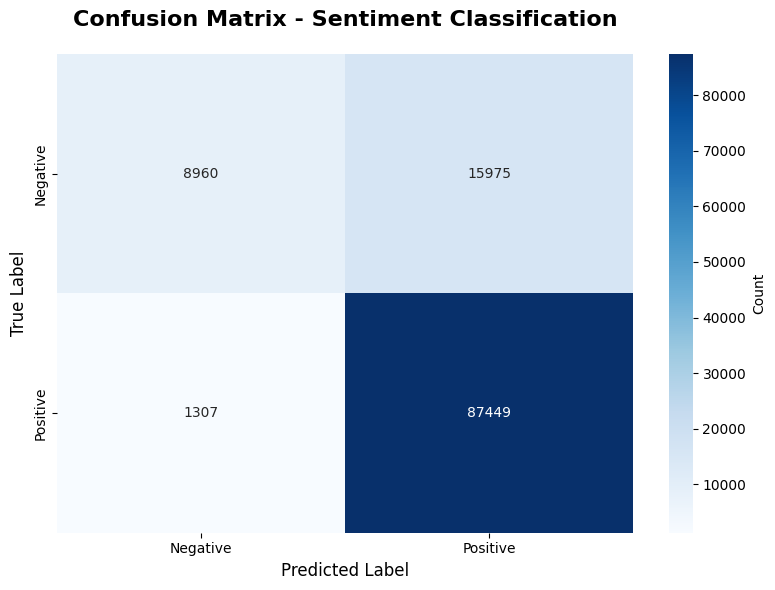

✓ Confusion matrix plotted!


In [16]:
# ============================================================================
# SEGMENT 9: VISUALIZE CONFUSION MATRIX
# ============================================================================
# Create a heatmap of the confusion matrix

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Sentiment Classification', 
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

print("✓ Confusion matrix plotted!")



In [17]:
# ============================================================================
# SEGMENT 10: TOP INDICATIVE WORDS
# ============================================================================
# Find the most important words for each sentiment class

print("\n" + "="*60)
print("TOP INDICATIVE WORDS FOR EACH SENTIMENT")
print("="*60)

feature_names = vectorizer.get_feature_names_out()
n_top = 20

# For each class (Negative and Positive)
for i, class_label in enumerate(['NEGATIVE', 'POSITIVE']):
    print(f"\n{class_label} Reviews - Top {n_top} Words:")
    print("-" * 60)
    
    # Get feature log probabilities and sort
    top_indices = model.feature_log_prob_[i].argsort()[-n_top:][::-1]
    
    print(f"{'Rank':<6} {'Word':<25} {'Log Probability':<15}")
    print("-" * 60)
    
    for rank, idx in enumerate(top_indices, 1):
        word = feature_names[idx]
        score = model.feature_log_prob_[i][idx]
        print(f"{rank:<6} {word:<25} {score:<15.4f}")




TOP INDICATIVE WORDS FOR EACH SENTIMENT

NEGATIVE Reviews - Top 20 Words:
------------------------------------------------------------
Rank   Word                      Log Probability
------------------------------------------------------------
1      like                      -5.0984        
2      br                        -5.2268        
3      taste                     -5.2358        
4      product                   -5.2826        
5      coffee                    -5.3547        
6      would                     -5.3998        
7      one                       -5.5394        
8      flavor                    -5.5445        
9      good                      -5.5555        
10     tea                       -5.7017        
11     dont                      -5.7478        
12     buy                       -5.8223        
13     food                      -5.8346        
14     get                       -5.8528        
15     much                      -5.8777        
16     really      

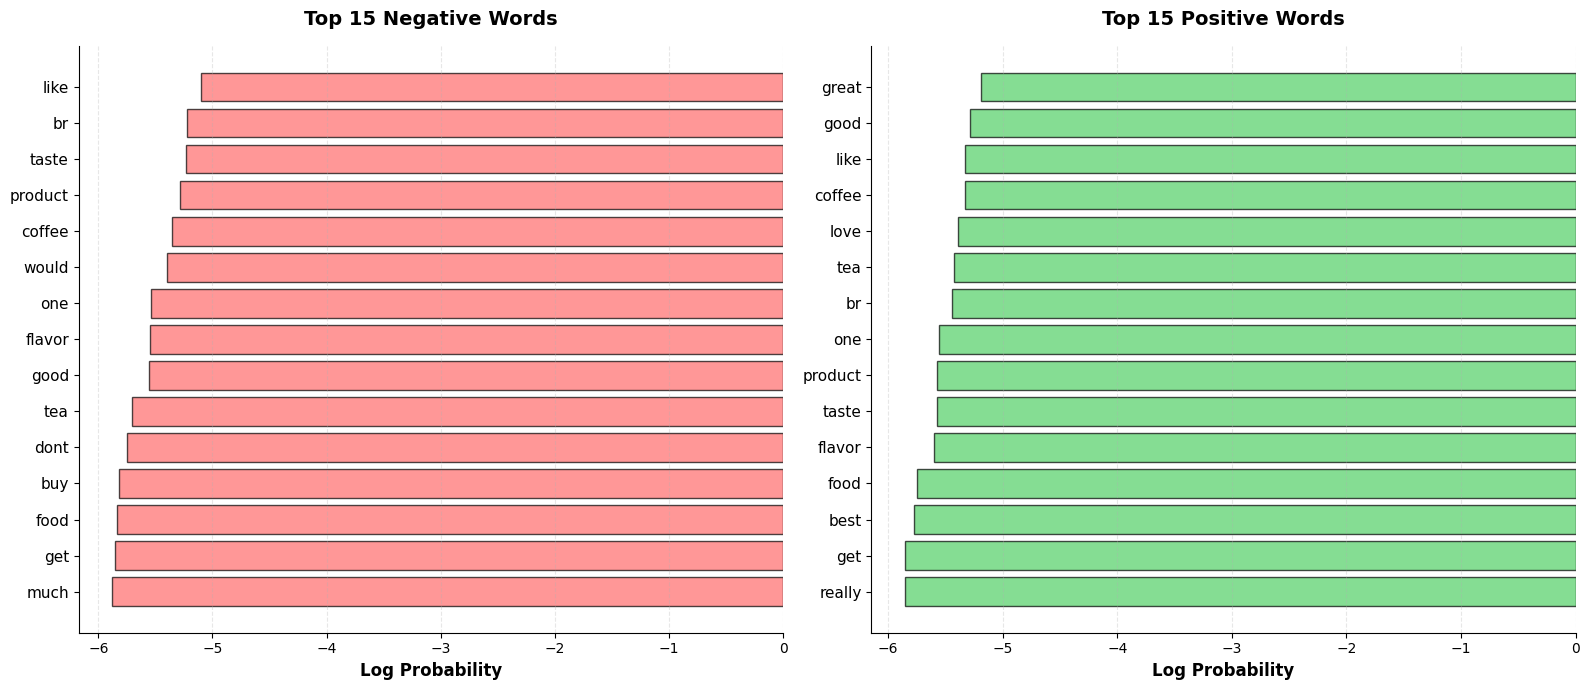

✓ Top words visualization complete!


In [18]:
# ============================================================================
# SEGMENT 11: VISUALIZE TOP WORDS
# ============================================================================
# Create bar charts showing top words for each sentiment

n_words = 15

fig, axes = plt.subplots(1, 2, figsize=(16, 7))
colors = ['#ff6b6b', '#51cf66']  # Red for negative, Green for positive

for i, (ax, class_label, color) in enumerate(zip(axes, ['Negative', 'Positive'], colors)):
    # Get top words and their scores
    top_indices = model.feature_log_prob_[i].argsort()[-n_words:][::-1]
    top_words = [feature_names[idx] for idx in top_indices]
    top_scores = [model.feature_log_prob_[i][idx] for idx in top_indices]
    
    # Create horizontal bar chart
    y_pos = np.arange(len(top_words))
    ax.barh(y_pos, top_scores, color=color, alpha=0.7, edgecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_words, fontsize=11)
    ax.invert_yaxis()
    ax.set_xlabel('Log Probability', fontsize=12, fontweight='bold')
    ax.set_title(f'Top {n_words} {class_label} Words', 
                fontsize=14, fontweight='bold', pad=15)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print("✓ Top words visualization complete!")



In [19]:
# ============================================================================
# SEGMENT 12: TEST WITH NEW REVIEWS
# ============================================================================
# Function to predict sentiment of new reviews

def predict_new_review(text):
    """Predict sentiment of a new review"""
    # Preprocess the text
    cleaned_text = preprocessor.preprocess(text)
    
    # Convert to TF-IDF features
    tfidf_features = vectorizer.transform([cleaned_text])
    
    # Make prediction
    prediction = model.predict(tfidf_features)[0]
    probabilities = model.predict_proba(tfidf_features)[0]
    
    # Get results
    sentiment = "Positive" if prediction == 1 else "Negative"
    confidence = probabilities[prediction] * 100
    
    # Display results
    print("="*60)
    print(f"Review: {text}")
    print("-"*60)
    print(f"Sentiment: {sentiment}")
    print(f"Confidence: {confidence:.2f}%")
    print(f"Probabilities - Negative: {probabilities[0]*100:.2f}%, Positive: {probabilities[1]*100:.2f}%")
    print("="*60)
    
    return sentiment, confidence

# Test with some example reviews
print("\nTesting the model with new reviews:\n")

test_reviews = [
    "This product is absolutely amazing! Best purchase ever!",
    "Terrible quality. Waste of money. Very disappointed.",
    "It's okay, nothing special but does the job.",
    "Love it! Exceeded my expectations. Highly recommend!",
    "Broke after one week. Poor customer service."
]

for review in test_reviews:
    predict_new_review(review)
    print()




Testing the model with new reviews:

Review: This product is absolutely amazing! Best purchase ever!
------------------------------------------------------------
Sentiment: Positive
Confidence: 93.38%
Probabilities - Negative: 6.62%, Positive: 93.38%

Review: Terrible quality. Waste of money. Very disappointed.
------------------------------------------------------------
Sentiment: Negative
Confidence: 96.85%
Probabilities - Negative: 96.85%, Positive: 3.15%

Review: It's okay, nothing special but does the job.
------------------------------------------------------------
Sentiment: Positive
Confidence: 60.55%
Probabilities - Negative: 39.45%, Positive: 60.55%

Review: Love it! Exceeded my expectations. Highly recommend!
------------------------------------------------------------
Sentiment: Positive
Confidence: 96.58%
Probabilities - Negative: 3.42%, Positive: 96.58%

Review: Broke after one week. Poor customer service.
------------------------------------------------------------
Sent

In [20]:
# ============================================================================
# SEGMENT 13: SUMMARY AND SAVE RESULTS
# ============================================================================
# Display final summary and save model if needed

print("\n" + "="*60)
print("PROJECT SUMMARY")
print("="*60)

print(f"\nDataset Information:")
print(f"  - Total reviews: {len(df)}")
print(f"  - Training samples: {len(X_train)}")
print(f"  - Test samples: {len(X_test)}")
print(f"  - Number of features: {len(feature_names)}")

print(f"\nModel Performance:")
print(f"  - Training Accuracy: {train_accuracy*100:.2f}%")
print(f"  - Test Accuracy: {test_accuracy*100:.2f}%")

# Calculate precision, recall, f1 for each class
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

print(f"\nNegative Class:")
print(f"  - Precision: {precision[0]*100:.2f}%")
print(f"  - Recall: {recall[0]*100:.2f}%")
print(f"  - F1-Score: {f1[0]*100:.2f}%")

print(f"\nPositive Class:")
print(f"  - Precision: {precision[1]*100:.2f}%")
print(f"  - Recall: {recall[1]*100:.2f}%")
print(f"  - F1-Score: {f1[1]*100:.2f}%")

print("\n" + "="*60)
print("✓ SENTIMENT ANALYSIS PROJECT COMPLETE!")
print("="*60)

# Optional: Save the model and vectorizer
# import pickle
# with open('sentiment_model.pkl', 'wb') as f:
#     pickle.dump(model, f)
# with open('tfidf_vectorizer.pkl', 'wb') as f:
#     pickle.dump(vectorizer, f)
# print("\n✓ Model and vectorizer saved!")


PROJECT SUMMARY

Dataset Information:
  - Total reviews: 568453
  - Training samples: 454762
  - Test samples: 113691
  - Number of features: 5000

Model Performance:
  - Training Accuracy: 84.93%
  - Test Accuracy: 84.80%

Negative Class:
  - Precision: 87.27%
  - Recall: 35.93%
  - F1-Score: 50.91%

Positive Class:
  - Precision: 84.55%
  - Recall: 98.53%
  - F1-Score: 91.01%

✓ SENTIMENT ANALYSIS PROJECT COMPLETE!
